<a href="https://colab.research.google.com/github/Baldros/Centrale-Nantes-Project/blob/main/DownloadData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Presentation:

    The purpose of this notebook is to address the data acquisition
    process. Since the dataset we will be using needs to undergo a
    process of acquisition and preprocessing in order to adjust it to
    the purpose of the activity, we will download and preprocess it
    here so that it serves the class's purpose well.

Documentation:
https://colab.research.google.com/notebooks/io.ipynb

In [ ]:
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00


# Download the data:

    The first step is to acquire the data. The data used here are
    provided by Meteo France and downloaded directly from their domain.
    For the scraping process of this data, I use the Selenium library
    for this purpose.
    
    Selenium is a very useful web automation library in these types
    of cases. It works in the background, and if you are using it in
    Colab, indeed, you won't see the process, only the result.

Documentation:
https://selenium-python.readthedocs.io/index.html

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--disable-dve-shm-uage')

driver = webdriver.Chrome(options=options)

In [ ]:
driver.get('https://meteonet.umr-cnrm.fr/dataset/data/NW/ground_stations/')

In [ ]:
# Access the page with the data
elements = driver.find_elements('xpath','/html/body/table/tbody/tr[position() >= 4 and position() <= 6]/td[2]/a')

# Iterate over the elements and download each file
for element in elements:
    # Get the URL of the link
    link_url = element.get_attribute("href")

    # Navigate to the URL of the link
    driver.get(link_url)

    # Wait for the download to complete
    WebDriverWait(driver, 60).until(EC.invisibility_of_element_located(('xpath', '//*[@id="download_progress"]')))
sleep(60)

# Unzipping files:

    The downloaded data comes in an uncompressed format, so there is
    a need to unzip it to work with it. Here, I will unzip it using
    two libraries native to the Python ecosystem.

Documentation:

tarfile: https://docs.python.org/3/library/tarfile.html

os: https://docs.python.org/pt-br/3/library/os.html


In [ ]:
import tarfile
import os

In [ ]:
# Define the directory where the files are located
download_dir = "/content"

In [ ]:
# Filtering files with tar.gz extension
tar_files = [file for file in os.listdir(download_dir) if file.endswith(".tar.gz")]

# Iterating over tar.gz files
for file_name in tar_files:
    # Complete path
    file_path = os.path.join(download_dir, file_name)

    # Extracting the tar.gz file
    with tarfile.open(file_path, 'r:gz') as tar:
        # Extract all members to the extraction directory
        tar.extractall(download_dir)

    # Remove the zip tar.gz files after extraction
    os.remove(file_path)
    print(f"File {file_name} extracted successfully.")


File NW_ground_stations_2018.tar.gz extracted successfully.
File NW_ground_stations_2017.tar.gz extracted successfully.
File NW_ground_stations_2016.tar.gz extracted successfully.


In [ ]:
# Filtering the csv files
csv_files = [file for file in os.listdir(download_dir) if file.endswith("csv")];csv_files

['NW2016.csv', 'NW2017.csv', 'NW2018.csv']

# Data Manipulation:

    Provavelmente, when it comes to data manipulation, you think of the
    Pandas library. However, here I'll introduce another library: Polars.
    Polars is another data manipulation library with performance comparable
    to Pandas. For example, given the limitations of Colab, I needed to use
    the Polars library here. I recommend that you try it out in your
    analyses.

    The idea here is to combine all subsets of all datasets downloaded
    from Meteo France into a single dataset, so that we have information
    from the 3 years provided, but without overloading our working environment.

Polar: https://pola.rs/

    Polars is a newer library, still not widely used, but it exhibits
    enormous capability and impressive results in data compression. Polars
    was benchmarked against several other solutions on the independent
    TPC-H Benchmark. This benchmark aims to replicate data wrangling
    operations used in practice. Polars easily trumps other solutions
    due to its parallel execution engine, efficient algorithms and use
    of vectorization with SIMD (Single Instruction, Multiple Data).
    Compared to pandas, it can achieve more than 30x performance gains.

In [ ]:
import polars as pl
from time import time

In [ ]:
tables = []
df = pl.read_csv(csv_files[0])[0:500];tables.append(df)
df = pl.read_csv(csv_files[1])[0:500];tables.append(df)
df = pl.read_csv(csv_files[2])[0:500];tables.append(df)

In [ ]:
df = pl.concat(tables,how='vertical');df

number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
i64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str
14066001,49.33,-0.43,2.0,"""20160101 00:00…",210.0,4.4,0.0,91.0,278.45,279.85,""" """
14126001,49.15,0.04,125.0,"""20160101 00:00…",null,null,0.0,99.0,278.35,278.45,""" """
14137001,49.18,-0.46,67.0,"""20160101 00:00…",220.0,0.6,0.0,92.0,276.45,277.65,"""102360.000 """
14216001,48.93,-0.15,155.0,"""20160101 00:00…",220.0,1.9,0.0,95.0,278.25,278.95,""" """
14296001,48.8,-1.03,339.0,"""20160101 00:00…",null,null,0.0,null,null,278.35,""" """
14357002,48.93,-0.69,223.0,"""20160101 00:00…",null,null,0.0,null,null,277.65,""" """
14366002,49.17,0.23,62.0,"""20160101 00:00…",null,null,0.0,null,null,279.55,""" """
14372001,49.102,-0.765,184.0,"""20160101 00:00…",230.0,4.1,0.0,92.0,278.05,279.25,""" """
14501002,48.89,-0.39,185.0,"""20160101 00:00…",null,null,0.0,null,null,278.35,""" """


# Visualization of the region:

    Visualizations are a great way to understand things. Since we are
    working with georeferenced data here, we can leverage that information
    to create georeferenced plots.

    To do this, we will use two solutions: Cartopy, a library designed
    for this purpose, and by downloading the files from the Meteo France
    GitHub to our working environment, we will use a solution created by
    the GitHub developers themselves.

cartopy:https://scitools.org.uk/cartopy/docs/latest/

In [ ]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 59.3 MB/s eta 0:00:00


In [ ]:
# github clone:
!git clone https://github.com/meteofrance/meteonet.git

Cloning into 'meteonet'...
remote: Enumerating objects: 2139, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2139 (delta 10), reused 8 (delta 8), pack-reused 2128
Receiving objects: 100% (2139/2139), 241.67 MiB | 18.59 MiB/s, done.
Resolving deltas: 100% (1149/1149), done.
Updating files: 100% (196/196), done.


In [ ]:
from meteonet.meteonet_toolbox.constant import DOMAINS
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


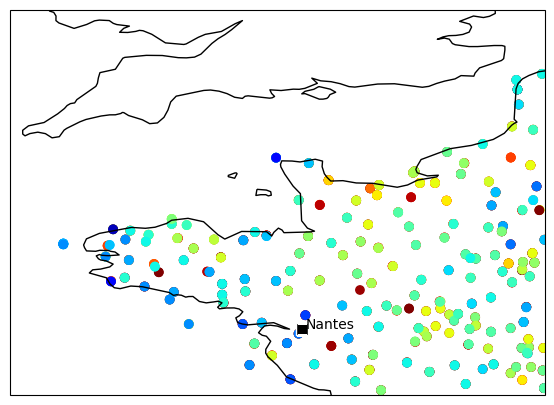

In [ ]:
# Coordinates of studied area boundaries
lllat = DOMAINS['NW']['lry']  #lower left latitude
urlat = DOMAINS['NW']['uly']  #upper right latitude
lllon = DOMAINS['NW']['ulx']  #lower left longitude
urlon = DOMAINS['NW']['lrx']  #upper right longitude
extent = [lllon, urlon, lllat, urlat]

# Nantes coordenates
nantes_lat = 47.2184
nantes_lon = -1.5536

fig = plt.figure(figsize=(9, 5))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
plt.scatter(df['lon'], df['lat'], c=df['hu'], cmap='jet')  # Plot

# Adding the coordenates of Nantes
plt.plot(nantes_lon, nantes_lat, marker='s', markerfacecolor='black', markeredgecolor='white', markersize=8) # Adding the mark
plt.text(nantes_lon + 0.05, nantes_lat + 0.005, 'Nantes', transform=ccrs.PlateCarree(), fontsize=10)  # # Adding the label

# Add coastlines and borders
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# Show only the area we defined
ax.set_extent(extent)


# Save the data:

In [ ]:
# Export dataset:
df.write_csv('dataset.csv')

In [ ]:
# Comunication with your drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the dataset in your drive:
!mv dataset.csv "/content/drive/MyDrive/"